## **Assignment 4: Feature Engineering & EDA - Healthcare Fraud**
**Author**: Danielle Myung (dm3930) <br>
**Date**: 6/21/2024

# Table of Contents
- <b>[Section 1: Data Preparation](#1)</b>
  - [1:1 Load Data & Background Information](#11)
  - [1:2 Data Tidying](#12)
- <b>[Section 2: Exploratory Data Analysis](#2)</b>
  - [2:1 Initial Observations](#21)
- <b>[Section 3: Feature Engineering](#3)</b>
  - <u>[Benchmark 1: Aggregating by State & DRG](#B1)</u>
      - [Feature 1: Ratio of Median Covered Charges ](#31)
      - [Feature 2: Ratio of Median Total Payments](#32)
      - [Feature 3: Ratio of Median Medicare Payment ](#33)
      - [Feature 4: Ratio of Median Patient Payments](#34)
  - <u>[Benchmark 2: Aggregating by Hospital /Provider Region & DRG](#B2)</u>
      - [Feature 5: Ratio of Median Covered Charges ](#35)
      - [Feature 6: Ratio of Median Total Payments](#36)
      - [Feature 7: Ratio of Median Medicare Payment ](#37)
      - [Feature 8: Ratio of Median Patient Payments](#38)
  - <u>[Benchmark 3: Aggregating by Region & Body System](#B3)</u>
      - [Feature 9: Ratio of Median Covered Charges ](#39)
  - <u>[Benchmark 4: Aggregating by DRG Level & Region](#B4)</u>
      - [Feature 10: Ratio of Median Covered Charges](#310)
- <b>[Section 4: Conclusion](#4)

# Section 1: Data Preparation <a class="anchor" id="1"></a>

## 1.1: Load Data & Background Information <a class="anchor" id="11"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [212]:
path = '/Users/danie/Downloads/' 
data = pd.read_csv(path + 'inpatientCharges.csv') #, encoding = "ISO-8859-1")    
data.head(5)  

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


### Understanding the Terminology

- **DRG Definition**: Diagnosis Related Group (DRG) is a system to classify hospital cases. It is used to categorize patients with similar clinical diagnoses and the procedures performed by the hospital during the stay. 
- **Total Discharges**: The number of discharges billed by all providers for inpatient hospital services. When you leave the hospital after treatment, you go through a process called hospital discharge.
### Understanding the Payment Process
- **Covered Charges**: The amount that hospitals charge for services. 
- **Payments**: The amount paid to the providers, including payments from Medicare, patient co-payments & deductibles, and any additional payments from third parties. 
- **Average Covered Charges**: Total Covered Charges / Total Discharges. Average amount that hospitals charge for services covered by Medicare for a specific DRG. 
- **Average Total Payments**: Total Payments / Total Discharges. The average total payments paid to providers for a specific DRG. 
- **Average Medicare Payments**: The average amount that Medicare pays to the provider for Medicare's share of the DRG. 

## 1.2: Data Tidying <a class="anchor" id="11"></a>

In [213]:
# column name tidying tidying
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

In [214]:
# Change data type and transfer spending amount with dollar sign into numeric
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Covered_Charges'] = (data['Average_Covered_Charges']
                              .str.replace('$', '').replace(',', '').astype(float))
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace('$', '').replace(',', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace('$', '').replace(',', '').astype(float))

Let's add an additional variable, " **Average_Patient_Payments**." This is the average difference between "*Average_Total_Payments*" and "*Average_Medicare_Payments*". This will calculate the average amount that the patient pays out of pocket for a specific DRG. This information will be relevant to our analysis down the line. 

In [217]:
data['Average_Patient_Payments'] = data['Average_Total_Payments'] - data['Average_Medicare_Payment']

### Grouping DRG Code by Body System

Grouping the DRG by bodily system may help us to identify if there is a certain group of codes or system that normally gets charged higher.

In [218]:
# Parse only numeric values of the DRG
data['System'] = data['DRG'].str.extract(r'(\d+)').astype(int)

In [219]:
# Function to categorize the DRG codes
def categorize_drg(code):
    if 39 <= code <= 149:
        return 'Neurology'
    elif 176 <= code <= 208:
        return 'Pulmonary'
    elif 238 <= code <= 315:
        return 'Cardiovascular'
    elif 329 <= code <= 439:
        return 'Gastrointestinal'
    elif 460 <= code <= 563:
        return 'Orthopedic'
    elif 602 <= code <= 603:
        return 'Infectious'
    elif 853 <= code <= 873:
        return 'Infectious'
    elif 638 <= code <= 638:
        return 'Diabetes'
    elif 682 <= code <= 699:
        return 'Nephrology'
    elif 811 <= code <= 812:
        return 'Hematology'
    elif 948 <= code <= 948:
        return 'Undiagnosed'
    else:
        return 'Miscellaneous'

# Apply the function to categorize the DRG codes
data['System'] = data['System'].apply(categorize_drg)

# Print the DataFrame to see the result
print(data[['DRG', 'System']])

                                             DRG       System
0       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    Neurology
1       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    Neurology
2       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    Neurology
3       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    Neurology
4       039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    Neurology
...                                          ...          ...
163060            948 - SIGNS & SYMPTOMS W/O MCC  Undiagnosed
163061            948 - SIGNS & SYMPTOMS W/O MCC  Undiagnosed
163062            948 - SIGNS & SYMPTOMS W/O MCC  Undiagnosed
163063            948 - SIGNS & SYMPTOMS W/O MCC  Undiagnosed
163064            948 - SIGNS & SYMPTOMS W/O MCC  Undiagnosed

[163065 rows x 2 columns]


In [220]:
# Make sure the data type changed successfully. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   DRG                            163065 non-null  category
 1   Provider_Id                    163065 non-null  category
 2   Provider_Name                  163065 non-null  object  
 3   Provider_StreetAddress         163065 non-null  object  
 4   Provider_City                  163065 non-null  category
 5   Provider_State                 163065 non-null  category
 6   Provider_Zipcode               163065 non-null  int64   
 7   Hospital_referral_region_desp  163065 non-null  object  
 8   Total_Discharges               163065 non-null  int64   
 9   Average_Covered_Charges        163065 non-null  float64 
 10  Average_Total_Payments         163065 non-null  float64 
 11  Average_Medicare_Payment       163065 non-null  float64 
 12  Average_Patient_

# Section 2: Exploratory Data Analysis <a class="anchor" id="2"></a>

## 2.1: Initial Observations <a class="anchor" id="21"></a>

### Plot Providers by State

Text(0.5, 1.0, 'Figure 1: Count of Providers by State')

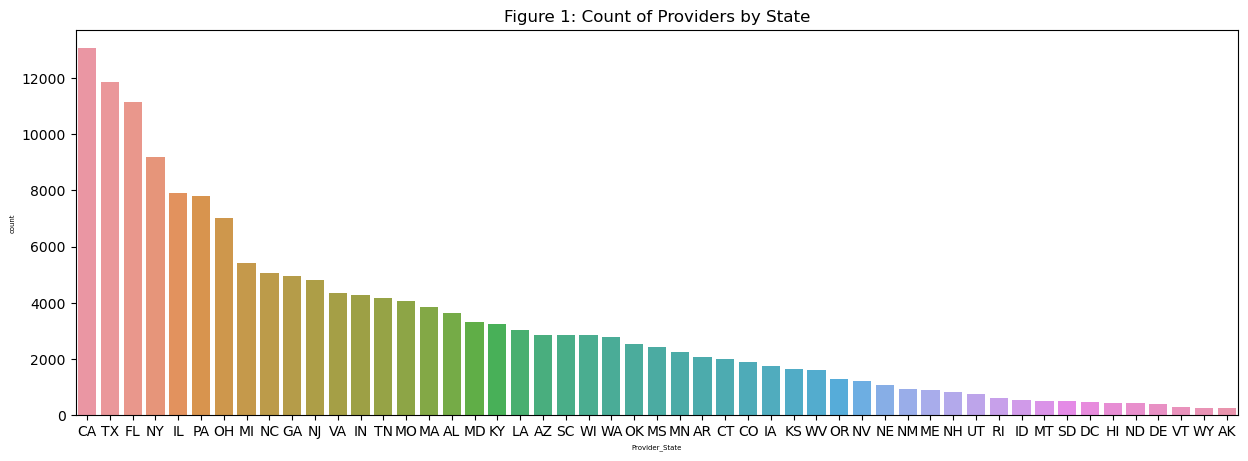

In [221]:
# data['Provider_State'].value_counts()
plt.figure(figsize=(15,5))
sns.countplot(x='Provider_State',data=data,order=data['Provider_State'].value_counts().index)
plt.rcParams["axes.labelsize"] = 5
plt.title("Figure 1: Count of Providers by State")

Overall, the count of providers by state correlates with the overall population of that state. Through this visualization, we can safely say that just because a provider or state has a high number of total discharges, they may not be fraudulent. 

### Top 10 Cities with the Highest Provider Count

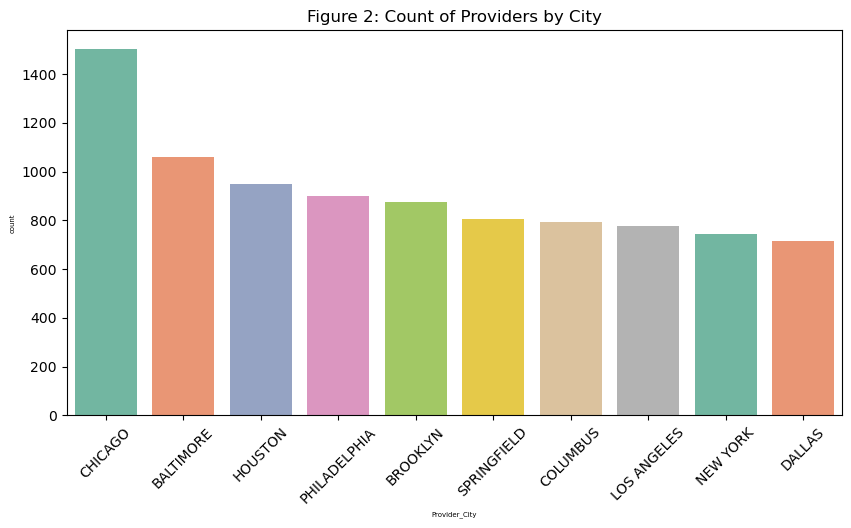

In [222]:
plt.figure(figsize=(10,5))
sns.countplot(x='Provider_City', data=data, order=data['Provider_City'].value_counts()[:10].index, palette = 'Set2')
plt.rcParams["axes.labelsize"] = 5
plt.title("Figure 2: Count of Providers by City")
plt.xticks(rotation=45);

This figure looks at the top 10 count of providers, nation wide. Interestingly, we can note a few observations here.
- Chicago, IL is the city that has the most count of providers, surpassing any city in CA, TX, FL, and NY.
- Baltimore, MD has the second highest count of providers, even though state-wide they have considerably fewer providers than other states.
- Illinois, New York State, and Texas all have 2 cities in the top 10 count of providers

### Count and Sum of Sytem DRGs

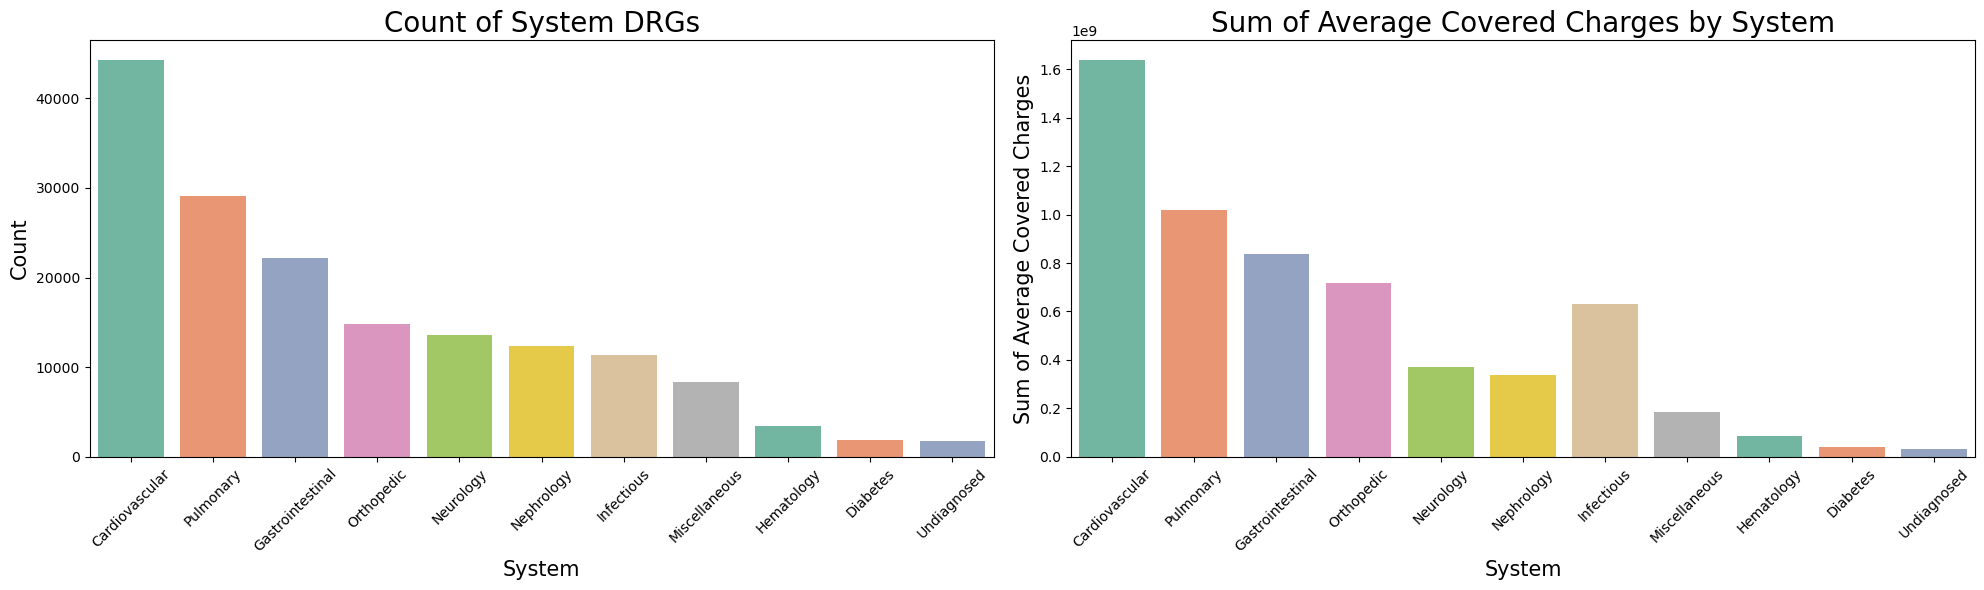

In [235]:
# 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Count of System DRGs
sns.countplot(x='System', data=data, order=data['System'].value_counts().index, palette='Set2', ax=axes[0])
axes[0].set_title('Count of System DRGs', size = 20)
axes[0].set_ylabel('Count', size = 15)
axes[0].set_xlabel('System', size = 15)
axes[0].tick_params(axis='x', rotation=45)

# Calculate the sum of Average_Covered_Charges for each System
sum_charges = data.groupby('System')['Average_Covered_Charges'].sum().reset_index()

# Plot 2: Sum of 'Average_Covered_Charges' by System
sns.barplot(x='System', y='Average_Covered_Charges', data=sum_charges, order=data['System'].value_counts().index, palette='Set2', ax=axes[1])
axes[1].set_title('Sum of Average Covered Charges by System', size = 20)
axes[1].set_ylabel('Sum of Average Covered Charges', size = 15)
axes[1].set_xlabel('System', size = 15)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- We see the highest count of discharged patients diagnosed with Cardiovascular, Pulmonary, and Gastrointestinal diagnoses.
- On the right, we can compare how much is charged by each system.
- Cardiovascular, pulomary, and gastrointestinal is highest ranked for the sum of "Average_Covered_Charges".
- We can see that Infectious disease, while having a relatively low count of system DRGs, is expensive and comprises a large sum of charges. 

### Averaged Covered Charges by State

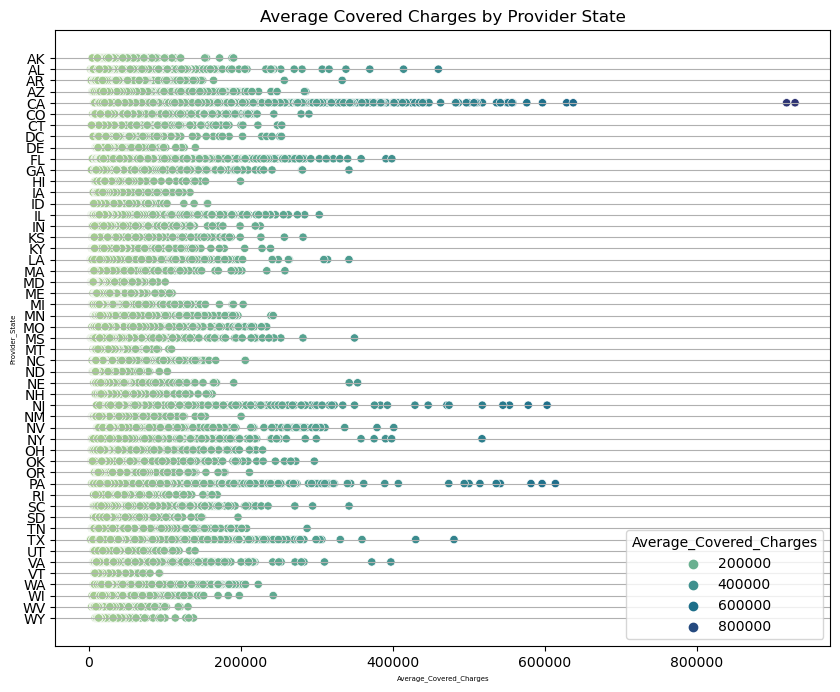

In [61]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, y='Provider_State', x='Average_Covered_Charges', hue='Average_Covered_Charges', palette = 'crest')
plt.title('Average Covered Charges by Provider State')
plt.grid(axis = 'y')
plt.show()

- California, New Jersey, and Pennsylvania all have very wide ranges of average covered charges, showing that there is high variance of their medical procedures. 

### Average Total Payments by State

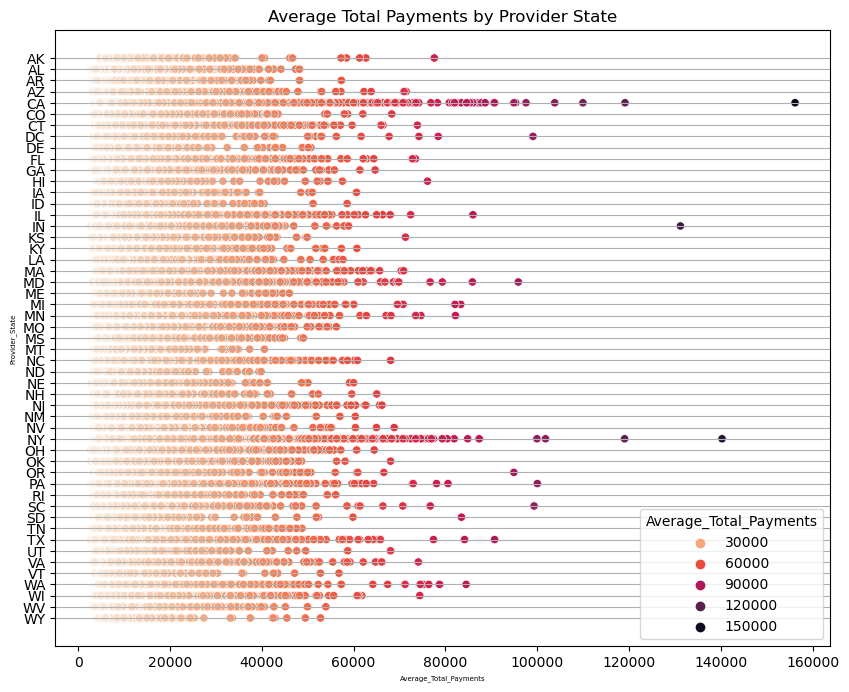

In [62]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, y='Provider_State', x='Average_Total_Payments', hue='Average_Total_Payments', palette = 'rocket_r')
plt.title('Average Total Payments by Provider State')
plt.grid(axis = 'y')
plt.show()

- California, Illinois, and New York State have the highest range of average total payments. These states have the most variation of payments amount that the providers are collecting.
- This in itself is not anomalous. More populous states tend to have wide ranges of economic regions, which may account for the high difference of payments.

### Descriptive Statistics of Average Total Payments, Grouped by DRG
- Grouping by DRG allows us to compare costs across different providers for the same DRG.
- If the average charge of DRG is much higher at one provider than the average, this will arouse suspicion and the provider can be further investigated.
- We will explore how this can be transformed into a feature in the future section

In [238]:
# Group by DRG, Let's look at some descriptive statistics for Average_Total_Payments
data.groupby("DRG")['Average_Total_Payments'].describe().reset_index()

,DRG,count,mean,std,min,25%,50%,75%,max
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1079.0,6960.534004,1477.873952,4968.00,6001.8300,6582.890,7516.825,18420.56
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,1201.0,6706.276445,2033.965862,4194.09,5412.8700,6093.750,7345.360,25519.43
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1659.0,13263.823032,3847.918207,8174.28,10762.2200,12084.700,14424.325,50882.40
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,2269.0,7922.671141,2084.658336,5368.73,6626.2700,7280.050,8503.060,26510.15
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1806.0,5713.985221,1342.538675,3916.41,4819.3250,5326.025,6197.480,14744.05
...,...,...,...,...,...,...,...,...,...
95,885 - PSYCHOSES,613.0,6968.721876,2440.280958,4444.90,5477.2400,6155.560,7841.280,32200.77
96,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,906.0,4949.907307,1462.463278,3172.44,3969.9675,4529.535,5440.675,18630.92
97,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,843.0,10763.814413,2823.004637,6942.83,8851.4550,10062.280,11788.675,33251.14
98,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,1382.0,4485.378734,1154.328951,3040.72,3720.5725,4136.105,4879.390,12479.80


In [239]:
agg_columns = ['mean', 'median', 'var', 'std', 'count', 'min', 'max']
groupby_drg = data[['DRG', 'Average_Total_Payments']].groupby(by='DRG', observed=False).agg(agg_columns)
groupby_drg.columns = [header + '-' + agg_column 
                       for header, agg_column in zip(groupby_drg.columns.get_level_values(0), agg_columns)]
groupby_drg.reset_index(inplace=True)

In [11]:
groupby_drg.head()

,DRG,Average_Total_Payments-mean,Average_Total_Payments-median,Average_Total_Payments-var,Average_Total_Payments-std,Average_Total_Payments-count,Average_Total_Payments-min,Average_Total_Payments-max
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6960.534004,6582.890,2.184111e+06,1477.873952,1079,4968.00,18420.56
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,6706.276445,6093.750,4.137017e+06,2033.965862,1201,4194.09,25519.43
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,13263.823032,12084.700,1.480647e+07,3847.918207,1659,8174.28,50882.40
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,7922.671141,7280.050,4.345800e+06,2084.658336,2269,5368.73,26510.15
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,5713.985221,5326.025,1.802410e+06,1342.538675,1806,3916.41,14744.05


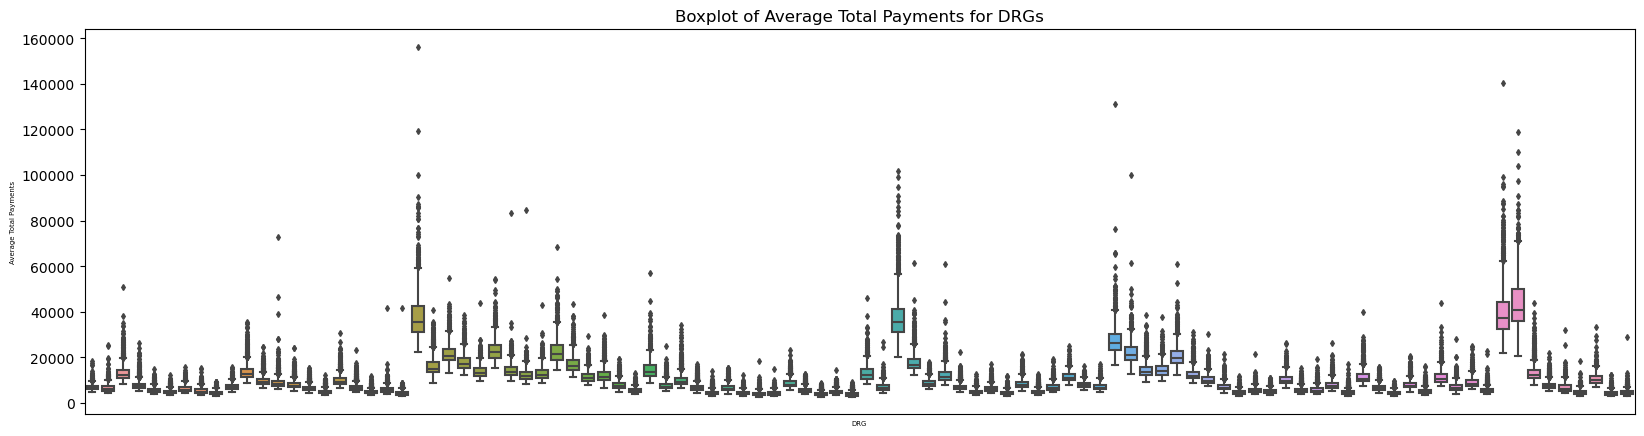

In [249]:
# Boxplot
plt.figure(figsize=(20,5))
sns.boxplot(x='DRG', y = 'Average_Total_Payments', data=data, fliersize = 3)
plt.xticks([])
plt.xlabel('DRG')
plt.ylabel('Average Total Payments')
plt.title('Boxplot of Average Total Payments for DRGs')
plt.show()

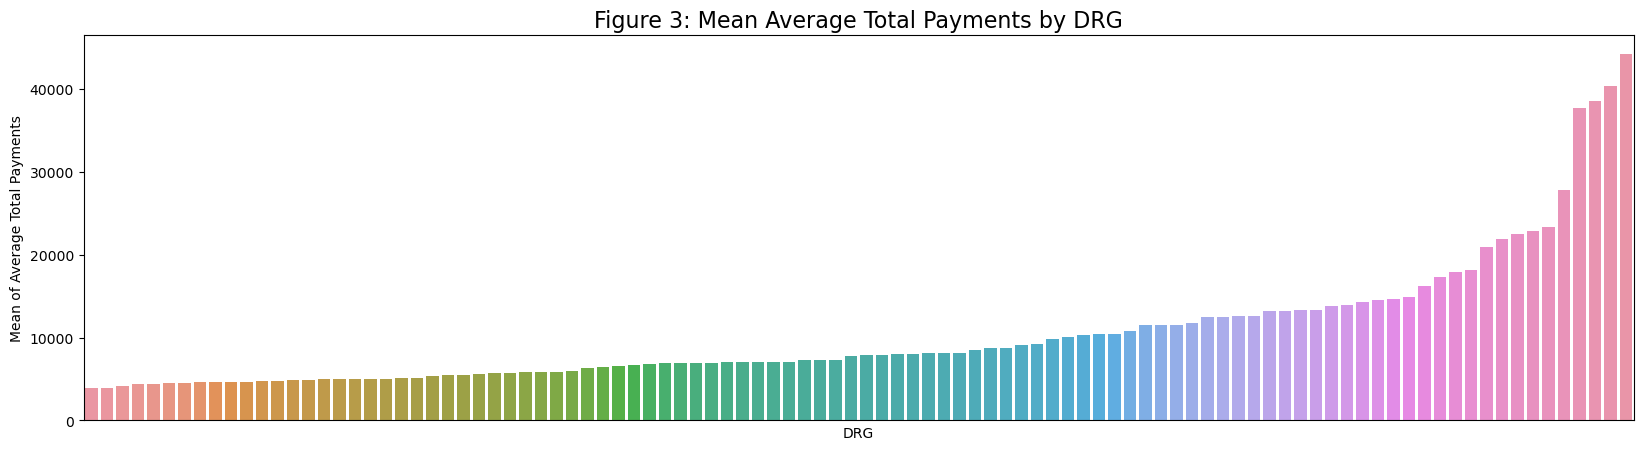

In [12]:
# Sort the DataFrame by 'Average_Total_Payments-mean'
sorted_drg = groupby_drg.sort_values('Average_Total_Payments-mean')

# Visualize the DRGs
plt.figure(figsize=(20, 5))
sns.barplot(x='DRG', y='Average_Total_Payments-mean', 
            data=sorted_drg, 
            order=sorted_drg['DRG'])
plt.title('Figure 3: Mean Average Total Payments by DRG', fontsize=16)
plt.ylabel('Mean of Average Total Payments', fontsize=10)
plt.xlabel('DRG', fontsize = 10)
plt.xticks([])
plt.show()

- This plot shows the mean average total payments grouped by DRG.
- Understandably, we can see that some DRG treatments are more costly than others, where the most expensive DRG costs \\$44,259 and the last expensive DRG costs \\$3,912.
- The range in itself is not anomalous, as we can logically say that the harder and more complicated procedures should rightfully incur higher costs.

#### Mean of Average Patient Payments, Grouped by DRG

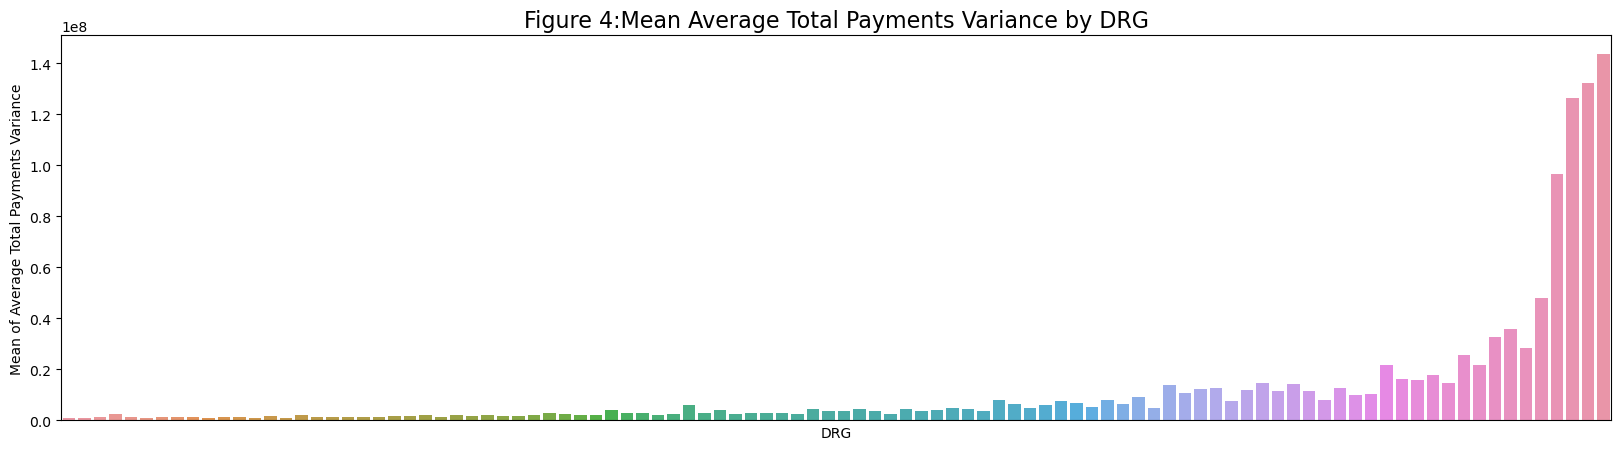

In [13]:
plt.figure(figsize=(20,5))
sns.barplot(x='DRG', y='Average_Total_Payments-var', 
            data=groupby_drg,
            order=sorted_drg['DRG'])
plt.title('Figure 4:Mean Average Total Payments Variance by DRG', fontsize=16)
plt.ylabel('Mean of Average Total Payments Variance', fontsize=10)
plt.xlabel('DRG', fontsize = 10)
plt.xticks([])
plt.show()

- Figure 4 shows the variance of average total payments by DRG, showing that the most expensive DRGs also have the highest variance in cost.
- Again, while this does not directly indicate anomalous or fraudulent activity, we can reasonably say that there can be cheaper options for the most expensive DRGs.
- Additionally, we can further analyze DRGs with high price variance to investigate the causes of the variance.

In [14]:
# Group by DRG, Let's look at some descriptive statistics for Average_Patient_Payments
data.groupby("DRG")['Average_Patient_Payments'].describe().reset_index()

,DRG,count,mean,std,min,25%,50%,75%,max
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1079.0,1404.696478,912.492377,611.64,948.7400,1122.160,1578.9800,14018.69
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,1201.0,1004.599875,454.271270,398.58,781.2300,887.140,1040.0000,4691.94
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1659.0,1150.973586,847.858725,258.77,774.2500,892.350,1213.3850,16330.63
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,2269.0,1141.169357,689.726553,408.73,880.3500,985.920,1230.9000,16922.83
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1806.0,1244.781661,481.946530,408.73,958.9400,1073.840,1391.3300,4816.63
...,...,...,...,...,...,...,...,...,...
95,885 - PSYCHOSES,613.0,1104.596232,839.924831,280.33,752.0000,884.990,1087.7000,9190.09
96,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,906.0,949.989603,502.668152,202.91,704.5075,838.865,1012.4375,5538.30
97,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,843.0,1196.993665,1100.352473,280.34,697.0800,853.330,1289.8350,14721.93
98,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,1382.0,954.984016,442.236051,238.00,714.5425,843.605,1053.7225,6709.78


In [15]:
# pbp = paid by patient
groupby_drg_pbp = data[['DRG', 'Average_Patient_Payments']].groupby(by='DRG').agg(agg_columns)
groupby_drg_pbp.columns = [header + '-' + agg_column 
                       for header, agg_column in zip(groupby_drg_pbp.columns.get_level_values(0), agg_columns)]
groupby_drg_pbp.reset_index(inplace=True)

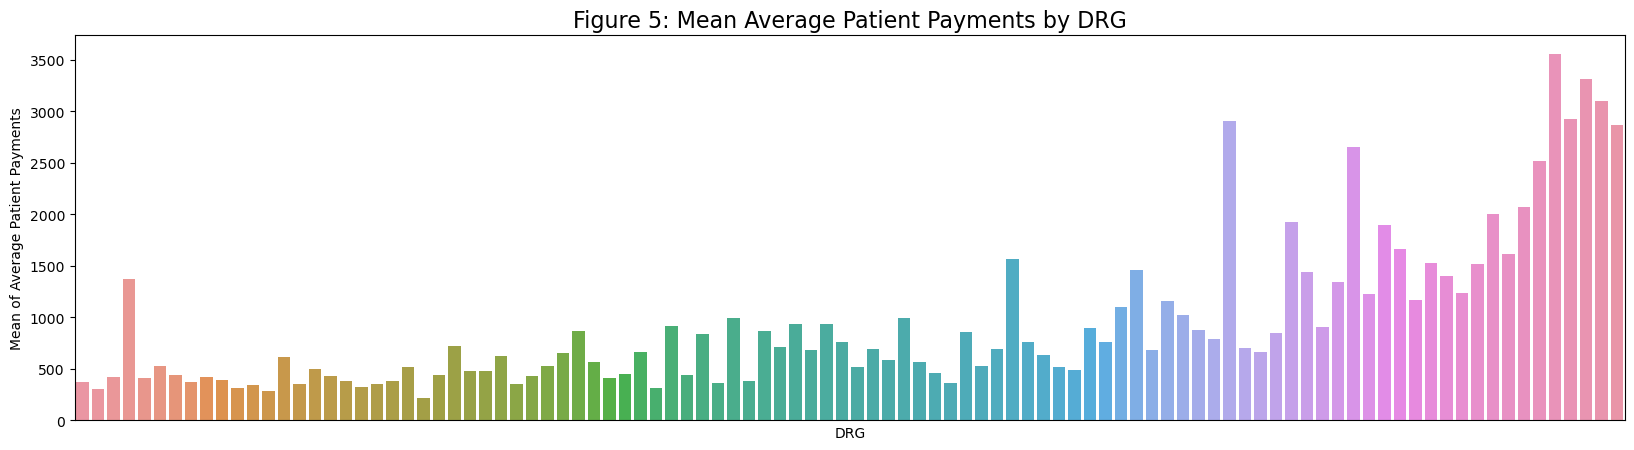

In [17]:
# Sort the DataFrame by 'Average_Patient_Payments-mean'
sorted_drg_pbp = groupby_drg_pbp.sort_values('Average_Patient_Payments-mean')

# Visualize the DRGs
plt.figure(figsize=(20, 5))
sns.barplot(x='DRG', y='Average_Patient_Payments-std', 
            data=sorted_drg_pbp, 
            order=sorted_drg['DRG'])
plt.title('Figure 5: Mean Average Patient Payments by DRG', fontsize=16)
plt.ylabel('Mean of Average Patient Payments', fontsize=10)
plt.xlabel('DRG', fontsize = 10)
plt.xticks([])
plt.show()

- Figure 5 plots the mean average amount that patients are paying for each DRG.
- The order of DRG is the same as Figure 3, so the two plots can be compared side-by-side to see for which DRGs patients typically pay out-of-pocket for. 

# Section 3: Feature Engineering  <a class="anchor" id="3"></a>

## Benchmark 1: Group by State & DRG  <a class="anchor" id="B1"></a>

- We will calculate the mean average payment **grouping by state**, for each DRG.
- This becomes our benchmark so we can compare the average amount that is typically charged for each DRG within the State.
- Grouping by Provider_State should account for some **confounding variables** such as specific state taxes and cost of living, which can **influence the overall healthcare cost** in each state. 

In [250]:
# create the benchmark table by State & DRG average for all the different payments
benchmark1 = data.groupby(['Provider_State', 'DRG'])[['Average_Covered_Charges', 'Average_Total_Payments', 'Average_Medicare_Payment', 'Average_Patient_Payments']].median().reset_index()
benchmark1.columns = ['Provider_State','DRG','Med_CoveredCharges_ByStateDRG', 'Med_TotPay_ByStateDRG', 'Med_MedicarePay_ByStateDRG', 'Med_PatientPay_ByStateDRG']
benchmark1.head()

# add the new feature back to the dataset
data1 = pd.merge(data, benchmark1, how = 'left', on = ['Provider_State', 'DRG'])
data1.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,Med_CoveredCharges_ByStateDRG,Med_TotPay_ByStateDRG,Med_MedicarePay_ByStateDRG,Med_PatientPay_ByStateDRG
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,Neurology,28523.39,5658.33,4471.68,1042.84
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,Neurology,28523.39,5658.33,4471.68,1042.84
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,Neurology,28523.39,5658.33,4471.68,1042.84
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,Neurology,28523.39,5658.33,4471.68,1042.84
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,Neurology,28523.39,5658.33,4471.68,1042.84


### Feature 1: Ratio of Median Covered Charges  <a class="anchor" id="31"></a>
- The Median Covered Charges by provider details the median amount charged by the provider for each DRG.
- I've opted to use the median amount here as median is less skewed by extreme outlier amounts
- It is worthwile to note that hospitals often do not receive the full payment amount of their covered charges.
- If the provider's covered charge for the DRG is much higher than the median, this may indicate suspicious activity and we may recommend further investigation. 

In [19]:
data1['Med_CoveredCharges_ByStateDRG_ratio'] = np.where(data1['Med_CoveredCharges_ByStateDRG']==0,0, data1['Average_Covered_Charges'] / data1['Med_CoveredCharges_ByStateDRG'])
data1['Med_CoveredCharges_ByStateDRG_ratio'].describe()

count    163065.000000
mean          1.073340
std           0.426845
min           0.116060
25%           0.801801
50%           1.000000
75%           1.251390
max           7.044009
Name: Med_CoveredCharges_ByStateDRG_ratio, dtype: float64

In [20]:
# cut by percentile for plotting
var = 'Med_CoveredCharges_ByStateDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data1[binned_var] = pd.qcut( data1[var],percentile)
data1[['Med_CoveredCharges_ByStateDRG_ratio_D']]

,Med_CoveredCharges_ByStateDRG_ratio_D
0,"(1.0, 1.334]"
1,"(0.399, 0.548]"
2,"(1.0, 1.334]"
3,"(0.399, 0.548]"
4,"(1.0, 1.334]"
...,...
163060,"(1.0, 1.334]"
163061,"(1.0, 1.334]"
163062,"(1.841, 2.508]"
163063,"(1.334, 1.841]"


[Text(0, 0, '(0.115, 0.399]'),
 Text(1, 0, '(0.399, 0.548]'),
 Text(2, 0, '(0.548, 0.755]'),
 Text(3, 0, '(0.755, 1.0]'),
 Text(4, 0, '(1.0, 1.334]'),
 Text(5, 0, '(1.334, 1.841]'),
 Text(6, 0, '(1.841, 2.508]'),
 Text(7, 0, '(2.508, 7.044]')]

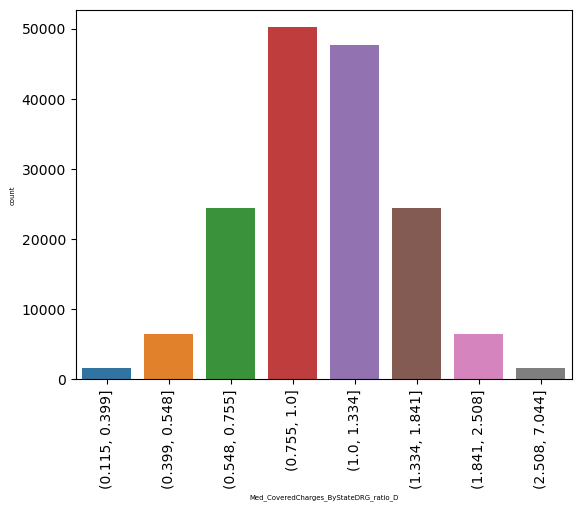

In [21]:
g = sns.countplot(x="Med_CoveredCharges_ByStateDRG_ratio_D", data=data1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [22]:
data1[data1['Med_CoveredCharges_ByStateDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,Med_CoveredCharges_ByStateDRG,Med_TotPay_ByStateDRG,Med_MedicarePay_ByStateDRG,Med_PatientPay_ByStateDRG,Med_CoveredCharges_ByStateDRG_ratio,Med_CoveredCharges_ByStateDRG_ratio_D
9,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,34,75233.38,5541.05,4386.94,1154.11,28523.390,5658.33,4471.680,1042.84,2.637603,"(2.508, 7.044]"
10,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10046,RIVERVIEW REGIONAL MEDICAL CENTER,600 SOUTH THIRD STREET,GADSDEN,AL,35901,AL - Birmingham,14,67327.92,5461.57,4493.57,968.00,28523.390,5658.33,4471.680,1042.84,2.360446,"(1.841, 2.508]"
22,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10139,BROOKWOOD MEDICAL CENTER,2010 BROOKWOOD MEDICAL CENTER DRIVE,BIRMINGHAM,AL,35209,AL - Birmingham,19,73846.21,4987.26,3944.42,1042.84,28523.390,5658.33,4471.680,1042.84,2.588970,"(2.508, 7.044]"
45,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30101,WESTERN ARIZONA REGIONAL MEDICAL CTR,2735 SILVER CREEK ROAD,BULLHEAD CITY,AZ,86442,NV - Las Vegas,26,60608.69,6941.03,5652.65,1288.38,29746.300,6959.89,5669.805,1121.06,2.037520,"(1.841, 2.508]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,98388.77,9838.11,8533.83,1304.28,23836.175,5890.00,4607.400,1114.58,4.127708,"(2.508, 7.044]"


### Feature 2: Ratio of Median Total Payments  <a class="anchor" id="32"></a>
- The median total payments by provider details the median amount paid to the provider for each DRG.
- I've opted to use the median amount here as median is less skewed by extreme outlier amounts
- It is worthwile to note that hospitals often do not receive the full payment amount of their covered charges.
- If the total payments charge for the DRG is much higher than the median, this may indicate suspicious activity and we may recommend further investigation. 

In [23]:
data1['Med_TotPay_ByStateDRG_ratio'] = np.where(data1['Med_TotPay_ByStateDRG']==0,0, data1['Average_Total_Payments'] / data1['Med_TotPay_ByStateDRG'])
data1['Med_TotPay_ByStateDRG_ratio'].describe()

count    163065.000000
mean          1.050746
std           0.211465
min           0.517695
25%           0.925511
50%           1.000000
75%           1.112126
max           9.338775
Name: Med_TotPay_ByStateDRG_ratio, dtype: float64

In [24]:
# cut by percentile for plotting
var = 'Med_TotPay_ByStateDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data1[binned_var] = pd.qcut( data1[var],percentile)
data1[['Med_TotPay_ByStateDRG_ratio_D']]

,Med_TotPay_ByStateDRG_ratio_D
0,"(1.0, 1.153]"
1,"(1.0, 1.153]"
2,"(0.908, 1.0]"
3,"(0.908, 1.0]"
4,"(0.908, 1.0]"
...,...
163060,"(0.83, 0.908]"
163061,"(0.908, 1.0]"
163062,"(1.153, 1.466]"
163063,"(1.466, 1.79]"


[Text(0, 0, '(0.517, 0.75]'),
 Text(1, 0, '(0.75, 0.83]'),
 Text(2, 0, '(0.83, 0.908]'),
 Text(3, 0, '(0.908, 1.0]'),
 Text(4, 0, '(1.0, 1.153]'),
 Text(5, 0, '(1.153, 1.466]'),
 Text(6, 0, '(1.466, 1.79]'),
 Text(7, 0, '(1.79, 9.339]')]

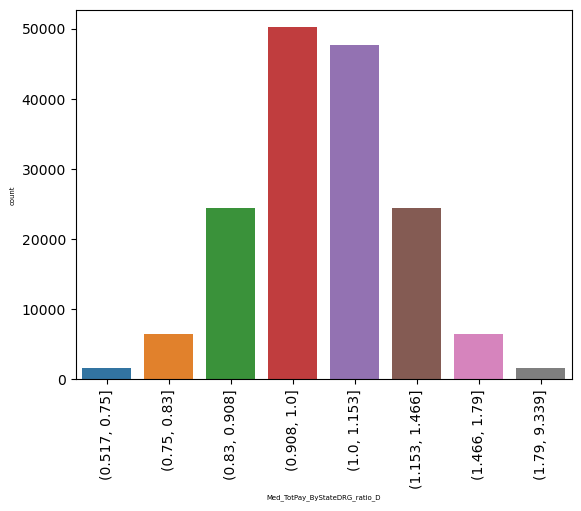

In [25]:
g = sns.countplot(x="Med_TotPay_ByStateDRG_ratio_D", data=data1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [26]:
data1[data1['Med_TotPay_ByStateDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Average_Medicare_Payment,Average_Patient_Payments,Med_CoveredCharges_ByStateDRG,Med_TotPay_ByStateDRG,Med_MedicarePay_ByStateDRG,Med_PatientPay_ByStateDRG,Med_CoveredCharges_ByStateDRG_ratio,Med_CoveredCharges_ByStateDRG_ratio_D,Med_TotPay_ByStateDRG_ratio,Med_TotPay_ByStateDRG_ratio_D
104,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50334,SALINAS VALLEY MEMORIAL HOSPITAL,450 EAST ROMIE LANE,SALINAS,CA,93901,CA - Salinas,17,53860.17,...,7051.05,9693.77,53860.170,7863.140,6639.330,1026.180,1.000000,"(0.755, 1.0]",2.129533,"(1.79, 9.339]"
280,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,140008,LOYOLA GOTTLIEB MEMORIAL HOSPITAL,701 WEST NORTH AVE,MELROSE PARK,IL,60160,IL - Melrose Park,16,56027.00,...,4401.87,14018.69,31701.265,6673.575,5264.365,1306.250,1.767343,"(1.334, 1.841]",2.760224,"(1.79, 9.339]"
294,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,140080,RHC ST FRANCIS HOSPITAL,355 RIDGE AVE,EVANSTON,IL,60202,IL - Evanston,12,48918.83,...,6934.08,10412.92,31701.265,6673.575,5264.365,1306.250,1.543119,"(1.334, 1.841]",2.599356,"(1.79, 9.339]"
1172,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50276,CONTRA COSTA REGIONAL MEDICAL CENTER,2500 ALHAMBRA AVE,MARTINEZ,CA,94553,CA - Contra Costa County,23,35616.60,...,18363.08,876.22,40782.875,7689.050,6800.435,845.035,0.873322,"(0.755, 1.0]",2.502169,"(1.79, 9.339]"
1191,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,16,148128.43,...,22553.56,2965.87,40782.875,7689.050,6800.435,845.035,3.632123,"(2.508, 7.044]",3.318931,"(1.79, 9.339]"


### Feature 3: Ratio of Median Medicare Payment  <a class="anchor" id="33"></a>
- The median total payments by provider details the median amount paid to the provider for each DRG.
- I've opted to use the median amount here as median is less skewed by extreme outlier amounts
- It is worthwile to note that hospitals often do not receive the full payment amount of their covered charges.
- If the total payments charge for the DRG is much higher than the median, this may indicate suspicious activity and we may recommend further investigation. 

In [27]:
data1['Med_MedicarePay_ByStateDRG_ratio'] = np.where(data1['Med_MedicarePay_ByStateDRG']==0,0, data1['Average_Medicare_Payment'] / data1['Med_MedicarePay_ByStateDRG'])
data1['Med_MedicarePay_ByStateDRG_ratio'].describe()

count    163065.000000
mean          1.055484
std           0.234139
min           0.367836
25%           0.916191
50%           1.000000
75%           1.121178
max           6.030981
Name: Med_MedicarePay_ByStateDRG_ratio, dtype: float64

In [28]:
# cut by percentile for plotting
var = 'Med_MedicarePay_ByStateDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data1[binned_var] = pd.qcut( data1[var],percentile)
data1[['Med_MedicarePay_ByStateDRG_ratio_D']]

,Med_MedicarePay_ByStateDRG_ratio_D
0,"(1.0, 1.167]"
1,"(1.0, 1.167]"
2,"(0.897, 1.0]"
3,"(0.897, 1.0]"
4,"(1.0, 1.167]"
...,...
163060,"(0.805, 0.897]"
163061,"(0.714, 0.805]"
163062,"(1.167, 1.527]"
163063,"(1.898, 6.031]"


[Text(0, 0, '(0.367, 0.714]'),
 Text(1, 0, '(0.714, 0.805]'),
 Text(2, 0, '(0.805, 0.897]'),
 Text(3, 0, '(0.897, 1.0]'),
 Text(4, 0, '(1.0, 1.167]'),
 Text(5, 0, '(1.167, 1.527]'),
 Text(6, 0, '(1.527, 1.898]'),
 Text(7, 0, '(1.898, 6.031]')]

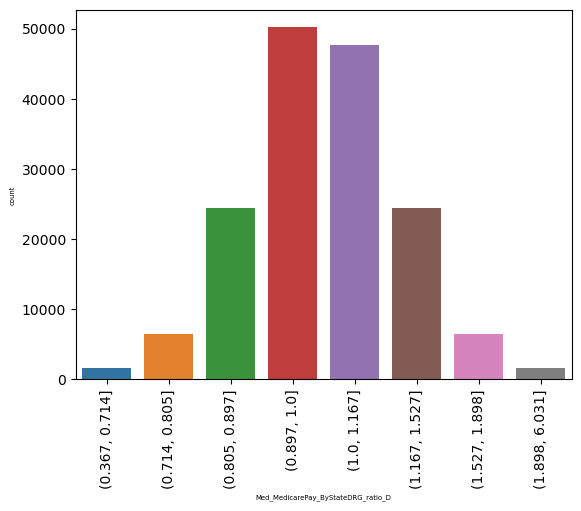

In [29]:
g = sns.countplot(x="Med_MedicarePay_ByStateDRG_ratio_D", data=data1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [30]:
data1[data1['Med_MedicarePay_ByStateDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_CoveredCharges_ByStateDRG,Med_TotPay_ByStateDRG,Med_MedicarePay_ByStateDRG,Med_PatientPay_ByStateDRG,Med_CoveredCharges_ByStateDRG_ratio,Med_CoveredCharges_ByStateDRG_ratio_D,Med_TotPay_ByStateDRG_ratio,Med_TotPay_ByStateDRG_ratio_D,Med_MedicarePay_ByStateDRG_ratio,Med_MedicarePay_ByStateDRG_ratio_D
456,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,210029,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,4940 EASTERN AVENUE,BALTIMORE,MD,21224,MD - Baltimore,11,17955.63,...,9103.140,8596.79,7340.710,1037.670,1.972466,"(1.841, 2.508]",1.963343,"(1.79, 9.339]",2.159897,"(1.898, 6.031]"
690,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,330195,LONG ISLAND JEWISH MEDICAL CENTER,270 - 05 76TH AVENUE,NEW HYDE PARK,NY,11040,NY - East Long Island,11,58074.18,...,21246.135,7561.72,6358.070,1165.050,2.733400,"(2.508, 7.044]",1.837557,"(1.79, 9.339]",2.088769,"(1.898, 6.031]"
1172,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50276,CONTRA COSTA REGIONAL MEDICAL CENTER,2500 ALHAMBRA AVE,MARTINEZ,CA,94553,CA - Contra Costa County,23,35616.60,...,40782.875,7689.05,6800.435,845.035,0.873322,"(0.755, 1.0]",2.502169,"(1.79, 9.339]",2.700280,"(1.898, 6.031]"
1186,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50376,LAC/HARBOR-UCLA MED CENTER,1000 W CARSON ST,TORRANCE,CA,90509,CA - Los Angeles,13,42594.69,...,40782.875,7689.05,6800.435,845.035,1.044426,"(1.0, 1.334]",1.959960,"(1.79, 9.339]",2.114718,"(1.898, 6.031]"
1191,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,16,148128.43,...,40782.875,7689.05,6800.435,845.035,3.632123,"(2.508, 7.044]",3.318931,"(1.79, 9.339]",3.316488,"(1.898, 6.031]"


### Feature 4: Ratio of Median Patient Payments  <a class="anchor" id="34"></a>
- The median total payments by provider details the median amount paid to the provider for each DRG.
- I've opted to use the median amount here as median is less skewed by extreme outlier amounts
- It is worthwile to note that hospitals often do not receive the full payment amount of their covered charges.
- If the total payments charge for the DRG is much higher than the median, this may indicate suspicious activity and we may recommend further investigation. 

In [31]:
data1['Med_PatientPay_ByStateDRG_ratio'] = np.where(data1['Med_PatientPay_ByStateDRG']==0,0, data1['Average_Patient_Payments'] / data1['Med_PatientPay_ByStateDRG'])
data1['Med_PatientPay_ByStateDRG_ratio'].describe()

count    163065.000000
mean          1.212557
std           0.946139
min           0.000000
25%           0.857963
50%           1.000000
75%           1.249538
max          78.801555
Name: Med_PatientPay_ByStateDRG_ratio, dtype: float64

In [32]:
# cut by percentile for plotting
var = 'Med_PatientPay_ByStateDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data1[binned_var] = pd.qcut( data1[var],percentile)
data1[['Med_PatientPay_ByStateDRG_ratio_D']]

,Med_PatientPay_ByStateDRG_ratio_D
0,"(0.822, 1.0]"
1,"(0.628, 0.822]"
2,"(0.822, 1.0]"
3,"(1.0, 1.364]"
4,"(0.628, 0.822]"
...,...
163060,"(0.822, 1.0]"
163061,"(1.364, 2.425]"
163062,"(1.364, 2.425]"
163063,"(1.0, 1.364]"


[Text(0, 0, '(-0.001, 0.44]'),
 Text(1, 0, '(0.44, 0.628]'),
 Text(2, 0, '(0.628, 0.822]'),
 Text(3, 0, '(0.822, 1.0]'),
 Text(4, 0, '(1.0, 1.364]'),
 Text(5, 0, '(1.364, 2.425]'),
 Text(6, 0, '(2.425, 4.718]'),
 Text(7, 0, '(4.718, 78.802]')]

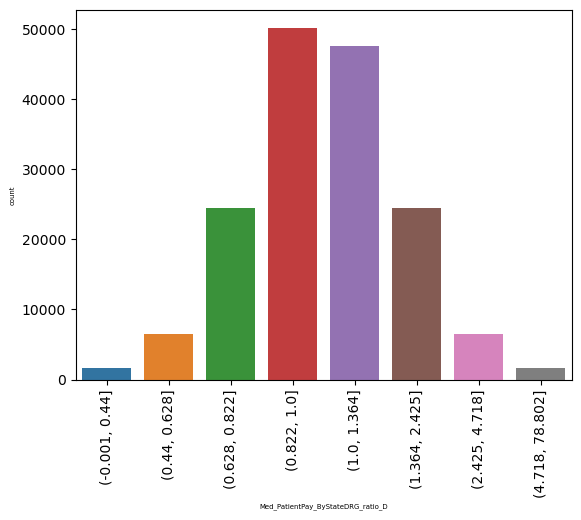

In [33]:
g = sns.countplot(x="Med_PatientPay_ByStateDRG_ratio_D", data=data1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [34]:
data1[data1['Med_PatientPay_ByStateDRG']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_MedicarePay_ByStateDRG,Med_PatientPay_ByStateDRG,Med_CoveredCharges_ByStateDRG_ratio,Med_CoveredCharges_ByStateDRG_ratio_D,Med_TotPay_ByStateDRG_ratio,Med_TotPay_ByStateDRG_ratio_D,Med_MedicarePay_ByStateDRG_ratio,Med_MedicarePay_ByStateDRG_ratio_D,Med_PatientPay_ByStateDRG_ratio,Med_PatientPay_ByStateDRG_ratio_D
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4471.68,1042.84,1.155651,"(1.0, 1.334]",1.021015,"(1.0, 1.153]",1.065311,"(1.0, 1.167]",0.971875,"(0.822, 1.0]"
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4471.68,1042.84,0.530507,"(0.399, 0.548]",1.022841,"(1.0, 1.153]",1.112940,"(1.0, 1.167]",0.777550,"(0.628, 0.822]"
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4471.68,1042.84,1.316827,"(1.0, 1.334]",0.960522,"(0.908, 1.0]",0.995999,"(0.897, 1.0]",0.940854,"(0.822, 1.0]"
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,4471.68,1042.84,0.490765,"(0.399, 0.548]",0.957449,"(0.908, 1.0]",0.923402,"(0.897, 1.0]",1.235472,"(1.0, 1.364]"
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4471.68,1042.84,1.109029,"(1.0, 1.334]",1.000000,"(0.908, 1.0]",1.084926,"(1.0, 1.167]",0.773743,"(0.628, 0.822]"


In [35]:
data1.columns

Index(['DRG', 'Provider_Id', 'Provider_Name', 'Provider_StreetAddress',
       'Provider_City', 'Provider_State', 'Provider_Zipcode',
       'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Covered_Charges', 'Average_Total_Payments',
       'Average_Medicare_Payment', 'Average_Patient_Payments',
       'Med_CoveredCharges_ByStateDRG', 'Med_TotPay_ByStateDRG',
       'Med_MedicarePay_ByStateDRG', 'Med_PatientPay_ByStateDRG',
       'Med_CoveredCharges_ByStateDRG_ratio',
       'Med_CoveredCharges_ByStateDRG_ratio_D', 'Med_TotPay_ByStateDRG_ratio',
       'Med_TotPay_ByStateDRG_ratio_D', 'Med_MedicarePay_ByStateDRG_ratio',
       'Med_MedicarePay_ByStateDRG_ratio_D', 'Med_PatientPay_ByStateDRG_ratio',
       'Med_PatientPay_ByStateDRG_ratio_D'],
      dtype='object')

In [36]:
# Create an empty dataframe to collect the features
features = pd.DataFrame()
features[['St', 'DRG']] = data[['Provider_State', 'DRG']]

# Add features 1 ~ 4 to the features dataset
features[['Med_CoveredCharges_ByStateDRG_ratio']] = data1[['Med_CoveredCharges_ByStateDRG_ratio']]
features[['Med_TotPay_ByStateDRG_ratio']] = data1[['Med_TotPay_ByStateDRG_ratio']]
features[['Med_MedicarePay_ByStateDRG_ratio']] = data1[['Med_MedicarePay_ByStateDRG_ratio']]
features[['Med_PatientPay_ByStateDRG_ratio']] = data1[['Med_PatientPay_ByStateDRG_ratio']]
features.head()

,St,DRG,Med_CoveredCharges_ByStateDRG_ratio,Med_TotPay_ByStateDRG_ratio,Med_MedicarePay_ByStateDRG_ratio,Med_PatientPay_ByStateDRG_ratio
0,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1.155651,1.021015,1.065311,0.971875
1,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,0.530507,1.022841,1.112940,0.777550
2,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1.316827,0.960522,0.995999,0.940854
3,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,0.490765,0.957449,0.923402,1.235472
4,AL,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1.109029,1.000000,1.084926,0.773743


### Visualize Feature 1 ~ 4

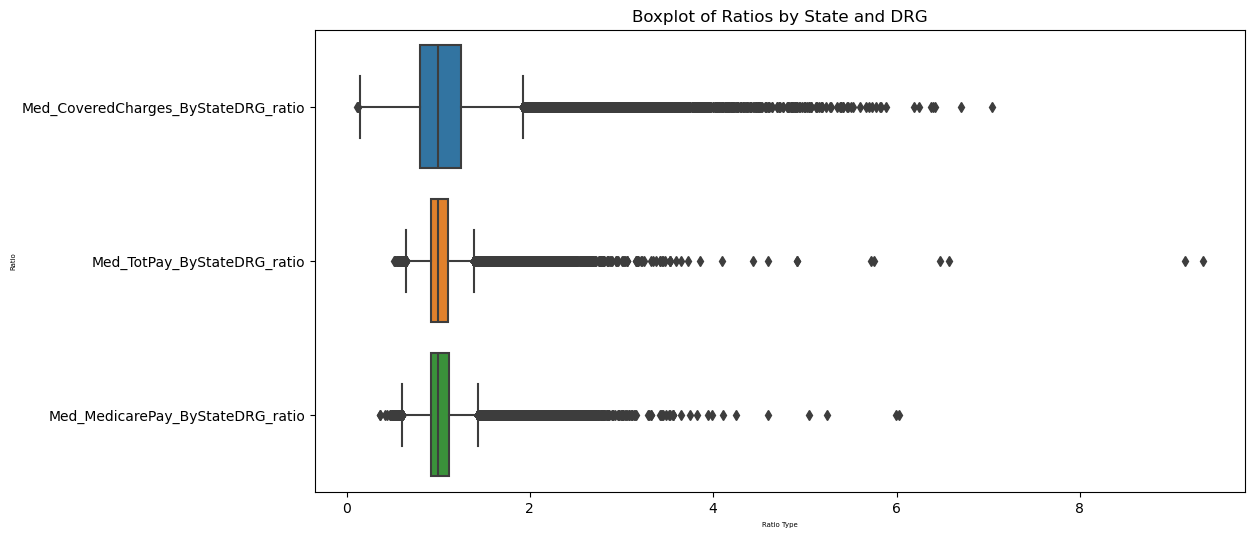

In [37]:
features_plot = features[['St', 'DRG','Med_CoveredCharges_ByStateDRG_ratio', 'Med_TotPay_ByStateDRG_ratio', 'Med_MedicarePay_ByStateDRG_ratio']]

features_melt = features_plot.melt(id_vars=['St', 'DRG'], var_name='Ratio_Type', value_name='Ratio_Value')

plt.figure(figsize=(12, 6))
sns.boxplot(y='Ratio_Type', x='Ratio_Value', data=features_melt)
plt.title('Boxplot of Ratios by State and DRG')
plt.ylabel('Ratio')
plt.xlabel('Ratio Type')
plt.show()

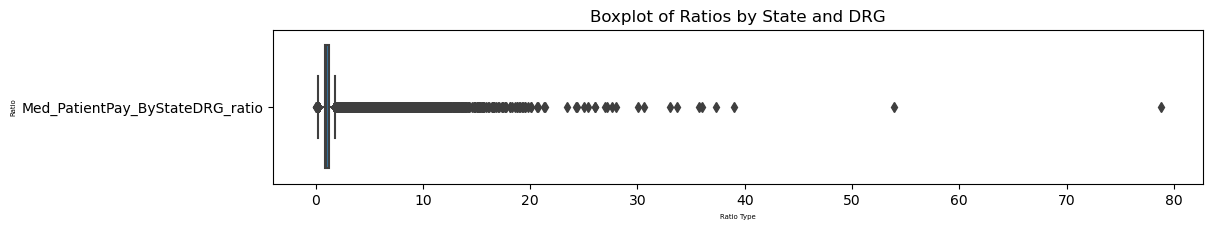

In [253]:
# Separately do Med_PatientPay_ByStateDRG_ratio since the scale is so much larger
features_plot = features[['St', 'DRG','Med_PatientPay_ByStateDRG_ratio']]

features_melt = features_plot.melt(id_vars=['St', 'DRG'], var_name='Ratio_Type', value_name='Ratio_Value')

plt.figure(figsize=(12,2))
sns.boxplot(y='Ratio_Type', x='Ratio_Value', data=features_melt)
plt.title('Boxplot of Ratios by State and DRG')
plt.ylabel('Ratio')
plt.xlabel('Ratio Type')
plt.show()

## Benchmark 2: Aggregating by by Hospital Region & DRG  <a class="anchor" id="B2"></a>
- Grouping by hospital region as opposed to grouping by state gives us a more narrow locational range in which we can compare median payment details.
- States, particularly very large states, can have **drastically differing costs of living and economic flow** between regions.
- By focusing our location to look at regions within the state, we expect there to be **more similarity in pricing across DRGs**.
- We may narrow our scope for what counts as an anomaly, as prices are expected to be **more consistent** within regions.
- This approach could offer a clearer understanding of payment patterns and anomalies in hospital data.

In [128]:
# create the benchmark table by Hospital Region & DRG average for all the different payments
benchmark2 = data.groupby(['Hospital_referral_region_desp', 'DRG'])[['Average_Covered_Charges', 'Average_Total_Payments', 'Average_Medicare_Payment', 'Average_Patient_Payments']].median().reset_index()
benchmark2.columns = ['Hospital_referral_region_desp','DRG','Med_CoveredCharges_ByRegDRG', 'Med_TotPay_ByRegDRG', 'Med_MedicarePay_ByRegDRG', 'Med_PatientPay_ByRegDRG']
benchmark2.head()

# add the new feature, Avg_Payment_ByStateDRG back to the dataset
data2 = pd.merge(data, benchmark2, how = 'left', on = ['Hospital_referral_region_desp', 'DRG'])
data2.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,Med_CoveredCharges_ByRegDRG,Med_TotPay_ByRegDRG,Med_MedicarePay_ByRegDRG,Med_PatientPay_ByRegDRG
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,Neurology,36285.175,5566.76,4585.965,980.795
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,Neurology,35841.090,5541.05,4471.680,1042.840
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,Neurology,35841.090,5541.05,4471.680,1042.840
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,Neurology,35841.090,5541.05,4471.680,1042.840
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,Neurology,35841.090,5541.05,4471.680,1042.840


### Feature 5: Ratio of Median Covered Charges  <a class="anchor" id="35"></a>

In [129]:
data2['Med_CoveredCharges_ByRegDRG_ratio'] = np.where(data2['Med_CoveredCharges_ByRegDRG']==0,0, data2['Average_Covered_Charges'] / data2['Med_CoveredCharges_ByRegDRG'])
data2['Med_CoveredCharges_ByRegDRG_ratio'].describe()

count    163065.000000
mean          1.053916
std           0.374415
min           0.084744
25%           0.848704
50%           1.000000
75%           1.170419
max           7.791253
Name: Med_CoveredCharges_ByRegDRG_ratio, dtype: float64

In [134]:
# cut by percentile for plotting
var = 'Med_CoveredCharges_ByRegDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data2[binned_var] = pd.qcut( data2[var],percentile)
data2[['Med_CoveredCharges_ByRegDRG_ratio_D']]

,Med_CoveredCharges_ByRegDRG_ratio_D
0,"(0.802, 1.0]"
1,"(0.0837, 0.43]"
2,"(1.0, 1.238]"
3,"(0.0837, 0.43]"
4,"(0.802, 1.0]"
...,...
163060,"(0.802, 1.0]"
163061,"(0.802, 1.0]"
163062,"(1.238, 1.711]"
163063,"(1.238, 1.711]"


[Text(0, 0, '(0.0837, 0.43]'),
 Text(1, 0, '(0.43, 0.589]'),
 Text(2, 0, '(0.589, 0.802]'),
 Text(3, 0, '(0.802, 1.0]'),
 Text(4, 0, '(1.0, 1.238]'),
 Text(5, 0, '(1.238, 1.711]'),
 Text(6, 0, '(1.711, 2.429]'),
 Text(7, 0, '(2.429, 7.791]')]

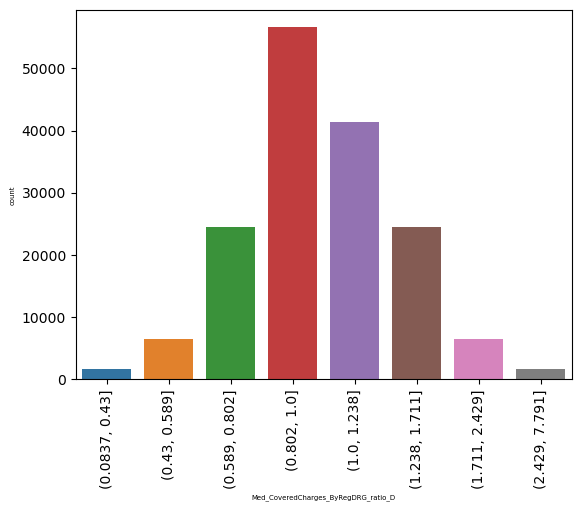

In [135]:
g = sns.countplot(x="Med_CoveredCharges_ByRegDRG_ratio_D", data=data2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [254]:
data2[data2['Med_CoveredCharges_ByRegDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_MedicarePay_ByRegDRG,Med_PatientPay_ByRegDRG,Med_CoveredCharges_ByRegDRG_ratio,Med_CoveredCharges_ByRegDRG_ratio_D,Med_TotPay_ByRegDRG_ratio,Med_TotPay_ByRegDRG_ratio_D,Med_MedicarePay_ByRegDRG_ratio,Med_MedicarePay_ByRegDRG_ratio_D,Med_PatientPay_ByRegDRG_ratio,Med_PatientPay_ByRegDRG_ratio_D
9,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,34,75233.38,...,4471.68,1042.84,2.099082,"(1.711, 2.429]",1.000000,"(0.926, 1.0]",0.981050,"(0.915, 1.0]",1.106699,"(1.0, 1.271]"
22,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10139,BROOKWOOD MEDICAL CENTER,2010 BROOKWOOD MEDICAL CENTER DRIVE,BIRMINGHAM,AL,35209,AL - Birmingham,19,73846.21,...,4471.68,1042.84,2.060378,"(1.711, 2.429]",0.900057,"(0.84, 0.926]",0.882089,"(0.816, 0.915]",1.000000,"(0.835, 1.0]"
32,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30024,ST JOSEPH'S HOSPITAL AND MEDICAL CENTER,350 WEST THOMAS ROAD,PHOENIX,AZ,85013,AZ - Phoenix,18,59443.83,...,6133.57,1064.78,2.080521,"(1.711, 2.429]",1.188576,"(1.109, 1.387]",1.210170,"(1.118, 1.43]",1.000000,"(0.835, 1.0]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,98388.77,...,4759.70,1054.11,4.017519,"(2.429, 7.791]",1.648355,"(1.387, 1.682]",1.792934,"(1.773, 5.734]",1.237328,"(1.0, 1.271]"
94,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50235,PROVIDENCE SAINT JOSEPH MEDICAL CTR,501 SOUTH BUENA VISTA,BURBANK,CA,91505,CA - Los Angeles,31,101282.03,...,6738.31,1065.69,2.395084,"(1.711, 2.429]",1.000000,"(0.926, 1.0]",1.133771,"(1.118, 1.43]",0.614841,"(0.394, 0.618]"


### Feature 6: Ratio of Median Total Payments  <a class="anchor" id="36"></a>

In [136]:
data2['Med_TotPay_ByRegDRG_ratio'] = np.where(data2['Med_TotPay_ByRegDRG']==0,0, data2['Average_Total_Payments'] / data2['Med_TotPay_ByRegDRG'])
data2['Med_TotPay_ByRegDRG_ratio'].describe()

count    163065.000000
mean          1.036331
std           0.179935
min           0.416786
25%           0.942559
50%           1.000000
75%           1.076226
max           8.618473
Name: Med_TotPay_ByRegDRG_ratio, dtype: float64

In [137]:
# cut by percentile for plotting
var = 'Med_TotPay_ByRegDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data2[binned_var] = pd.qcut( data2[var],percentile)
data2[['Med_TotPay_ByRegDRG_ratio_D']]

,Med_TotPay_ByRegDRG_ratio_D
0,"(1.0, 1.109]"
1,"(1.0, 1.109]"
2,"(0.926, 1.0]"
3,"(0.926, 1.0]"
4,"(1.0, 1.109]"
...,...
163060,"(0.762, 0.84]"
163061,"(0.762, 0.84]"
163062,"(1.109, 1.387]"
163063,"(1.682, 8.618]"


[Text(0, 0, '(0.416, 0.762]'),
 Text(1, 0, '(0.762, 0.84]'),
 Text(2, 0, '(0.84, 0.926]'),
 Text(3, 0, '(0.926, 1.0]'),
 Text(4, 0, '(1.0, 1.109]'),
 Text(5, 0, '(1.109, 1.387]'),
 Text(6, 0, '(1.387, 1.682]'),
 Text(7, 0, '(1.682, 8.618]')]

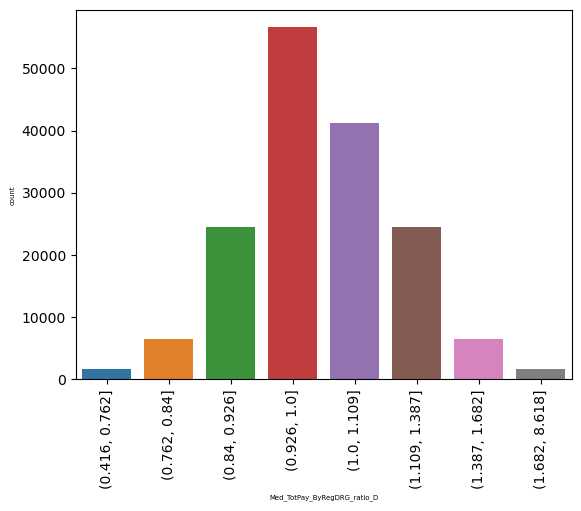

In [138]:
g = sns.countplot(x="Med_TotPay_ByRegDRG_ratio_D", data=data2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [255]:
data2[data2['Med_TotPay_ByRegDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_MedicarePay_ByRegDRG,Med_PatientPay_ByRegDRG,Med_CoveredCharges_ByRegDRG_ratio,Med_CoveredCharges_ByRegDRG_ratio_D,Med_TotPay_ByRegDRG_ratio,Med_TotPay_ByRegDRG_ratio_D,Med_MedicarePay_ByRegDRG_ratio,Med_MedicarePay_ByRegDRG_ratio_D,Med_PatientPay_ByRegDRG_ratio,Med_PatientPay_ByRegDRG_ratio_D
280,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,140008,LOYOLA GOTTLIEB MEMORIAL HOSPITAL,701 WEST NORTH AVE,MELROSE PARK,IL,60160,IL - Melrose Park,16,56027.00,...,4792.970,2260.025,1.359774,"(1.238, 1.711]",2.561296,"(1.682, 8.618]",0.918401,"(0.915, 1.0]",6.202892,"(4.028, 59.373]"
294,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,140080,RHC ST FRANCIS HOSPITAL,355 RIDGE AVE,EVANSTON,IL,60202,IL - Evanston,12,48918.83,...,6033.225,1742.685,1.756960,"(1.711, 2.429]",2.230864,"(1.682, 8.618]",1.149316,"(1.118, 1.43]",5.975216,"(4.028, 59.373]"
1172,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50276,CONTRA COSTA REGIONAL MEDICAL CENTER,2500 ALHAMBRA AVE,MARTINEZ,CA,94553,CA - Contra Costa County,23,35616.60,...,7382.920,930.690,0.573750,"(0.43, 0.589]",2.293906,"(1.682, 8.618]",2.487238,"(1.773, 5.734]",0.941474,"(0.835, 1.0]"
1547,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,210002,UNIVERSITY OF MARYLAND MEDICAL CENTER,22 S GREENE ST,BALTIMORE,MD,21201,MD - Baltimore,55,18303.49,...,7217.850,920.290,2.114381,"(1.711, 2.429]",2.112115,"(1.682, 8.618]",2.197337,"(1.773, 5.734]",1.467679,"(1.271, 2.127]"
1554,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,83,26402.79,...,7217.850,920.290,3.049996,"(2.429, 7.791]",3.051527,"(1.682, 8.618]",3.169017,"(1.773, 5.734]",2.164665,"(2.127, 4.028]"


### Feature 7: Ratio of Median Medicare Payment  <a class="anchor" id="37"></a>

In [139]:
data2['Med_MedicarePay_ByRegDRG_ratio'] = np.where(data2['Med_MedicarePay_ByRegDRG']==0,0, data2['Average_Medicare_Payment'] / data2['Med_MedicarePay_ByRegDRG'])
data2['Med_MedicarePay_ByRegDRG_ratio'].describe()

count    163065.000000
mean          1.038494
std           0.196388
min           0.331728
25%           0.935187
50%           1.000000
75%           1.082952
max           5.733904
Name: Med_MedicarePay_ByRegDRG_ratio, dtype: float64

In [140]:
# cut by percentile for plotting
var = 'Med_MedicarePay_ByRegDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data2[binned_var] = pd.qcut( data2[var],percentile)
data2[['Med_MedicarePay_ByRegDRG_ratio_D']]

,Med_MedicarePay_ByRegDRG_ratio_D
0,"(1.0, 1.118]"
1,"(1.0, 1.118]"
2,"(0.915, 1.0]"
3,"(0.915, 1.0]"
4,"(1.0, 1.118]"
...,...
163060,"(0.915, 1.0]"
163061,"(0.331, 0.727]"
163062,"(1.118, 1.43]"
163063,"(1.773, 5.734]"


[Text(0, 0, '(0.331, 0.727]'),
 Text(1, 0, '(0.727, 0.816]'),
 Text(2, 0, '(0.816, 0.915]'),
 Text(3, 0, '(0.915, 1.0]'),
 Text(4, 0, '(1.0, 1.118]'),
 Text(5, 0, '(1.118, 1.43]'),
 Text(6, 0, '(1.43, 1.773]'),
 Text(7, 0, '(1.773, 5.734]')]

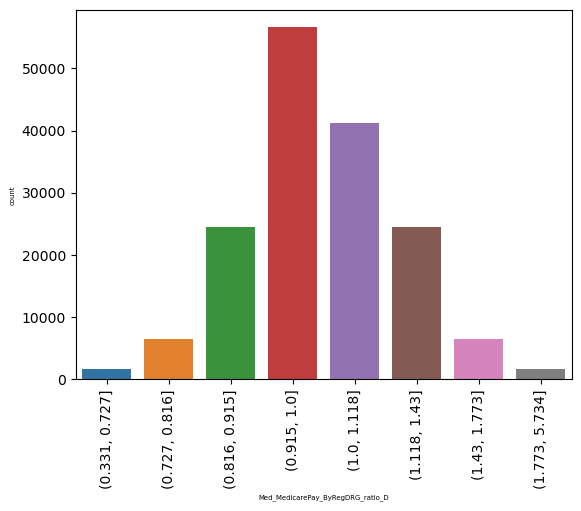

In [141]:
g = sns.countplot(x="Med_MedicarePay_ByRegDRG_ratio_D", data=data2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [256]:
data2[data2['Med_MedicarePay_ByRegDRG_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_MedicarePay_ByRegDRG,Med_PatientPay_ByRegDRG,Med_CoveredCharges_ByRegDRG_ratio,Med_CoveredCharges_ByRegDRG_ratio_D,Med_TotPay_ByRegDRG_ratio,Med_TotPay_ByRegDRG_ratio_D,Med_MedicarePay_ByRegDRG_ratio,Med_MedicarePay_ByRegDRG_ratio_D,Med_PatientPay_ByRegDRG_ratio,Med_PatientPay_ByRegDRG_ratio_D
456,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,210029,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,4940 EASTERN AVENUE,BALTIMORE,MD,21224,MD - Baltimore,11,17955.63,...,7541.520,1054.97,1.943246,"(1.711, 2.429]",1.937180,"(1.682, 8.618]",2.102385,"(1.773, 5.734]",0.969952,"(0.835, 1.0]"
690,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,330195,LONG ISLAND JEWISH MEDICAL CENTER,270 - 05 76TH AVENUE,NEW HYDE PARK,NY,11040,NY - East Long Island,11,58074.18,...,5902.065,1857.26,2.147192,"(1.711, 2.429]",1.792257,"(1.682, 8.618]",2.250151,"(1.773, 5.734]",0.330891,"(-0.001, 0.394]"
1172,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50276,CONTRA COSTA REGIONAL MEDICAL CENTER,2500 ALHAMBRA AVE,MARTINEZ,CA,94553,CA - Contra Costa County,23,35616.60,...,7382.920,930.69,0.573750,"(0.43, 0.589]",2.293906,"(1.682, 8.618]",2.487238,"(1.773, 5.734]",0.941474,"(0.835, 1.0]"
1186,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50376,LAC/HARBOR-UCLA MED CENTER,1000 W CARSON ST,TORRANCE,CA,90509,CA - Los Angeles,13,42594.69,...,6956.130,847.18,0.983346,"(0.802, 1.0]",1.959034,"(1.682, 8.618]",2.067385,"(1.773, 5.734]",0.813558,"(0.618, 0.835]"
1547,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,210002,UNIVERSITY OF MARYLAND MEDICAL CENTER,22 S GREENE ST,BALTIMORE,MD,21201,MD - Baltimore,55,18303.49,...,7217.850,920.29,2.114381,"(1.711, 2.429]",2.112115,"(1.682, 8.618]",2.197337,"(1.773, 5.734]",1.467679,"(1.271, 2.127]"


### Feature 8: Ratio of Median Patient Payments  <a class="anchor" id="38"></a>

In [143]:
data2['Med_PatientPay_ByRegDRG_ratio'] = np.where(data2['Med_PatientPay_ByRegDRG']==0,0, data2['Average_Patient_Payments'] / data2['Med_PatientPay_ByRegDRG'])
data2['Med_PatientPay_ByRegDRG_ratio'].describe()

count    163065.000000
mean          1.151622
std           0.792775
min           0.000000
25%           0.875063
50%           1.000000
75%           1.182176
max          59.373373
Name: Med_PatientPay_ByRegDRG_ratio, dtype: float64

In [144]:
# cut by percentile for plotting
var = 'Med_PatientPay_ByRegDRG_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data2[binned_var] = pd.qcut( data2[var],percentile)
data2[['Med_PatientPay_ByRegDRG_ratio_D']]

,Med_PatientPay_ByRegDRG_ratio_D
0,"(1.0, 1.271]"
1,"(0.618, 0.835]"
2,"(0.835, 1.0]"
3,"(1.0, 1.271]"
4,"(0.618, 0.835]"
...,...
163060,"(0.835, 1.0]"
163061,"(1.271, 2.127]"
163062,"(1.271, 2.127]"
163063,"(0.835, 1.0]"


[Text(0, 0, '(-0.001, 0.394]'),
 Text(1, 0, '(0.394, 0.618]'),
 Text(2, 0, '(0.618, 0.835]'),
 Text(3, 0, '(0.835, 1.0]'),
 Text(4, 0, '(1.0, 1.271]'),
 Text(5, 0, '(1.271, 2.127]'),
 Text(6, 0, '(2.127, 4.028]'),
 Text(7, 0, '(4.028, 59.373]')]

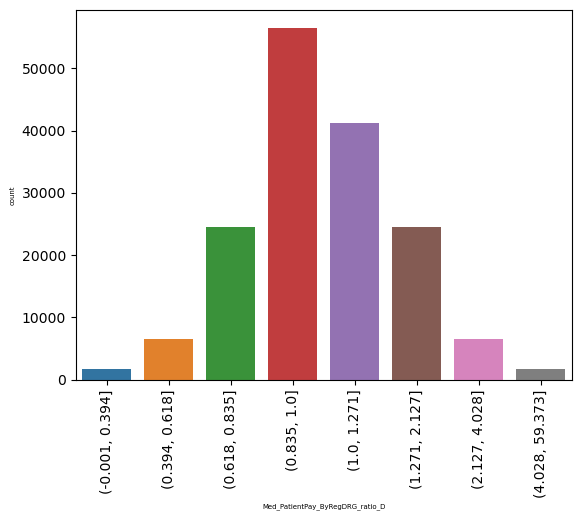

In [145]:
g = sns.countplot(x="Med_PatientPay_ByRegDRG_ratio_D", data=data2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [257]:
data2[data2['Med_PatientPay_ByRegDRG']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Med_MedicarePay_ByRegDRG,Med_PatientPay_ByRegDRG,Med_CoveredCharges_ByRegDRG_ratio,Med_CoveredCharges_ByRegDRG_ratio_D,Med_TotPay_ByRegDRG_ratio,Med_TotPay_ByRegDRG_ratio_D,Med_MedicarePay_ByRegDRG_ratio,Med_MedicarePay_ByRegDRG_ratio_D,Med_PatientPay_ByRegDRG_ratio,Med_PatientPay_ByRegDRG_ratio_D
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4585.965,980.795,0.908445,"(0.802, 1.0]",1.037810,"(1.0, 1.109]",1.038763,"(1.0, 1.118]",1.033356,"(1.0, 1.271]"
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4471.680,1042.840,0.422193,"(0.0837, 0.43]",1.044490,"(1.0, 1.109]",1.112940,"(1.0, 1.118]",0.777550,"(0.618, 0.835]"
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4471.680,1042.840,1.047970,"(1.0, 1.238]",0.980852,"(0.926, 1.0]",0.995999,"(0.915, 1.0]",0.940854,"(0.835, 1.0]"
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,4471.680,1042.840,0.390565,"(0.0837, 0.43]",0.977714,"(0.926, 1.0]",0.923402,"(0.915, 1.0]",1.235472,"(1.0, 1.271]"
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4471.680,1042.840,0.882598,"(0.802, 1.0]",1.021166,"(1.0, 1.109]",1.084926,"(1.0, 1.118]",0.773743,"(0.618, 0.835]"


## Benchmark 3: Aggregating by Region & Body System  <a class="anchor" id="B3"></a>
- Let's see if we can identify a body system that gets consistently abused for fraudulent activity.
- Providers might be trying to 'hide' a fraudulent activity amongst commonly used bodily systems.
- If we see a higher than median dollar amount in a system, this might promote further investigation. 

In [146]:
# create the benchmark table by Hospital Region & DRG average for just Average_Covered_Charges
benchmark3 = data.groupby(['Hospital_referral_region_desp', 'System'])[['Average_Covered_Charges']].median().reset_index()
benchmark3.columns = ['Hospital_referral_region_desp','System','Med_CoveredCharges_ByRegSys']
benchmark3.head()

# add the new feature, Avg_Payment_ByStateDRG back to the dataset
data3 = pd.merge(data, benchmark3, how = 'left', on = ['Hospital_referral_region_desp', 'System'])
data3.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,Med_CoveredCharges_ByRegSys
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,Neurology,24751.27
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,Neurology,21577.61
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,Neurology,21577.61
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,Neurology,21577.61
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,Neurology,21577.61


### Feature 9: Ratio of Median Covered Charges  <a class="anchor" id="39"></a>

In [147]:
data3['Med_CoveredCharges_ByRegSys_ratio'] = np.where(data3['Med_CoveredCharges_ByRegSys']==0,0, data3['Average_Covered_Charges'] / data3['Med_CoveredCharges_ByRegSys'])
data3['Med_CoveredCharges_ByRegSys_ratio'].describe()

count    163065.000000
mean          1.284712
std           0.997947
min           0.088281
25%           0.713563
50%           1.000000
75%           1.491773
max          20.669120
Name: Med_CoveredCharges_ByRegSys_ratio, dtype: float64

In [148]:
# cut by percentile for plotting
var = 'Med_CoveredCharges_ByRegSys_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data3[binned_var] = pd.qcut( data3[var],percentile)
data3[['Med_CoveredCharges_ByRegSys_ratio_D']]

,Med_CoveredCharges_ByRegSys_ratio_D
0,"(1.0, 1.677]"
1,"(0.656, 1.0]"
2,"(1.677, 3.097]"
3,"(0.435, 0.656]"
4,"(1.0, 1.677]"
...,...
163060,"(0.656, 1.0]"
163061,"(0.656, 1.0]"
163062,"(1.0, 1.677]"
163063,"(1.0, 1.677]"


[Text(0, 0, '(0.0873, 0.304]'),
 Text(1, 0, '(0.304, 0.435]'),
 Text(2, 0, '(0.435, 0.656]'),
 Text(3, 0, '(0.656, 1.0]'),
 Text(4, 0, '(1.0, 1.677]'),
 Text(5, 0, '(1.677, 3.097]'),
 Text(6, 0, '(3.097, 5.361]'),
 Text(7, 0, '(5.361, 20.669]')]

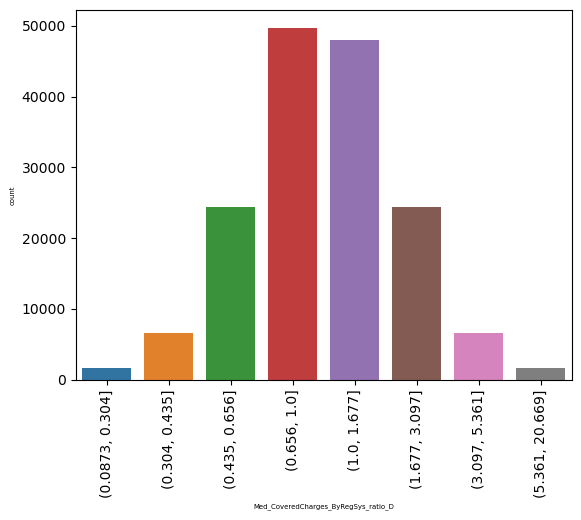

In [149]:
g = sns.countplot(x="Med_CoveredCharges_ByRegSys_ratio_D", data=data3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [150]:
data3[data3['Med_CoveredCharges_ByRegSys_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,Med_CoveredCharges_ByRegSys,Med_CoveredCharges_ByRegSys_ratio,Med_CoveredCharges_ByRegSys_ratio_D
9,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,34,75233.38,5541.05,4386.94,1154.11,Neurology,21577.61,3.486641,"(3.097, 5.361]"
10,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10046,RIVERVIEW REGIONAL MEDICAL CENTER,600 SOUTH THIRD STREET,GADSDEN,AL,35901,AL - Birmingham,14,67327.92,5461.57,4493.57,968.00,Neurology,21577.61,3.120268,"(3.097, 5.361]"
19,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10103,BAPTIST MEDICAL CENTER-PRINCETON,701 PRINCETON AVENUE SOUTHWEST,BIRMINGHAM,AL,35211,AL - Birmingham,33,51343.75,5996.00,4962.45,1033.55,Neurology,21577.61,2.379492,"(1.677, 3.097]"
20,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10104,TRINITY MEDICAL CENTER,800 MONTCLAIR RD,BIRMINGHAM,AL,35213,AL - Birmingham,29,55219.31,5710.31,4471.68,1238.63,Neurology,21577.61,2.559102,"(1.677, 3.097]"
22,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10139,BROOKWOOD MEDICAL CENTER,2010 BROOKWOOD MEDICAL CENTER DRIVE,BIRMINGHAM,AL,35209,AL - Birmingham,19,73846.21,4987.26,3944.42,1042.84,Neurology,21577.61,3.422354,"(3.097, 5.361]"


## Benchmark 4: Categorize DRG based on MCC, CC, or W/O CC/MCC  <a class="anchor" id="B4"></a>
- Let's break down the DRG medical code a bit more
  - **MCC**: Major complication or comorbidity
  - **CC**: Complication or comorbidity
  - **W/O MCC/CC**: Without major or regular complication or comorbidity
- Logically, MCC and CC codes should be most costly than W/O MCC/CC codes - **but how much more**? 
- We can group by the **different intensity levels of the codes**, and see if any providers have a large deviation from the median value by hospital region.

In [258]:
# create a new column - 'DRG_Category' - that houses the medical code intensity
def categorize_drg(drg):
    if 'W/O CC/MCC' in drg:
        return 'W/O CC/MCC'
    elif 'W/O MCC' in drg:
        return 'W/O CC/MCC'        
    elif 'W CC' in drg:
        return 'CC'
    elif 'W MCC' in drg:
        return 'MCC'
    elif '/MCC/' in drg:
        return 'MCC'
    else:
        return 'N/A'
data['DRG_Category'] = data['DRG'].apply(categorize_drg)

In [260]:
# Create a new column - "DRG_No_Details" that only has the diagnosis name without numbers or intensity level 

# Remove numbers and dashes
data['DRG_No_Details'] = data['DRG'].str.replace(r'\d+\s*-\s*', '', regex = True)
# Remove "W/O CC/MCC"
data['DRG_No_Details'] = data['DRG_No_Details'].str.replace(r'\s*W\s*/?\s*O\s*CC/MCC', '', regex=True)
# Remove "W/O MCC"
data['DRG_No_Details'] = data['DRG_No_Details'].str.replace(r'\s*W\s*/?\s*O\s*MCC', '', regex=True)
# Remove "W CC"
data['DRG_No_Details'] = data['DRG_No_Details'].str.replace(r'\s*W\s*/?\s*CC', '', regex=True)
# Remove "W MCC"
data['DRG_No_Details'] = data['DRG_No_Details'].str.replace(r'\s*W\s*/?\s*MCC', '', regex=True)
# Remove "/MCC"
data['DRG_No_Details'] = data['DRG_No_Details'].str.replace(r'/MCC', '', regex=True)
data[['DRG', 'DRG_No_Details', 'DRG_Category', 'Provider_Id', 'Provider_State', 'Hospital_referral_region_desp', 'Average_Covered_Charges']].head()

,DRG,DRG_No_Details,DRG_Category,Provider_Id,Provider_State,Hospital_referral_region_desp,Average_Covered_Charges
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,EXTRACRANIAL PROCEDURES,W/O CC/MCC,10001,AL,AL - Dothan,32963.07
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,EXTRACRANIAL PROCEDURES,W/O CC/MCC,10005,AL,AL - Birmingham,15131.85
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,EXTRACRANIAL PROCEDURES,W/O CC/MCC,10006,AL,AL - Birmingham,37560.37
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,EXTRACRANIAL PROCEDURES,W/O CC/MCC,10011,AL,AL - Birmingham,13998.28
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,EXTRACRANIAL PROCEDURES,W/O CC/MCC,10016,AL,AL - Birmingham,31633.27


## Create the Benchmark

In [261]:
# create the benchmark table by Hospital Region & DRG average for just Average_Covered_Charges
benchmark4 = data.groupby(['Hospital_referral_region_desp', 'DRG_No_Details', 'DRG_Category'])[['Average_Covered_Charges']].median().reset_index()
benchmark4.columns = ['Hospital_referral_region_desp','DRG_No_Details','DRG_Category', 'Med_CoveredCharges_ByCategory']
# benchmark4.head()

# add the new feature back to the dataset
data4 = pd.merge(data, benchmark4, how = 'left', on = ['Hospital_referral_region_desp', 'DRG_No_Details', 'DRG_Category'])
data4.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,DRG_Category,DRG_No_Details,Med_CoveredCharges_ByCategory
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,36285.175
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.090
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.090
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.090
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.090


### Feature 10: Ratio of Median Covered Charges by DRG_Category, Region <a class="anchor" id="310"></a>

In [202]:
data4['Med_CoveredCharges_ByCategory_ratio'] = np.where(data4['Med_CoveredCharges_ByCategory']==0,0, data4['Average_Covered_Charges'] / data4['Med_CoveredCharges_ByCategory'])
data4['Med_CoveredCharges_ByCategory_ratio'].describe()

count    163065.000000
mean          1.053916
std           0.374415
min           0.084744
25%           0.848704
50%           1.000000
75%           1.170419
max           7.791253
Name: Med_CoveredCharges_ByCategory_ratio, dtype: float64

In [204]:
# cut by percentile for plotting
var = 'Med_CoveredCharges_ByCategory_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
data4[binned_var] = pd.qcut( data4[var],percentile)
data4[['Med_CoveredCharges_ByCategory_ratio_D']]

,Med_CoveredCharges_ByCategory_ratio_D
0,"(0.802, 1.0]"
1,"(0.0837, 0.43]"
2,"(1.0, 1.238]"
3,"(0.0837, 0.43]"
4,"(0.802, 1.0]"
...,...
163060,"(0.802, 1.0]"
163061,"(0.802, 1.0]"
163062,"(1.238, 1.711]"
163063,"(1.238, 1.711]"


[Text(0, 0, '(0.0837, 0.43]'),
 Text(1, 0, '(0.43, 0.589]'),
 Text(2, 0, '(0.589, 0.802]'),
 Text(3, 0, '(0.802, 1.0]'),
 Text(4, 0, '(1.0, 1.238]'),
 Text(5, 0, '(1.238, 1.711]'),
 Text(6, 0, '(1.711, 2.429]'),
 Text(7, 0, '(2.429, 7.791]')]

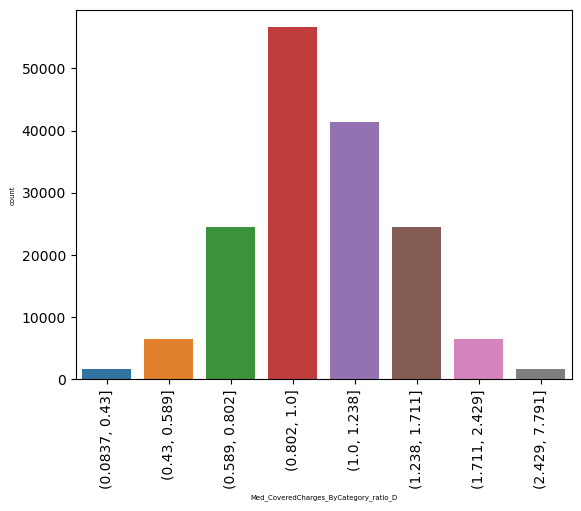

In [205]:
g = sns.countplot(x="Med_CoveredCharges_ByCategory_ratio_D", data=data4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [206]:
data4[data4['Med_CoveredCharges_ByCategory_ratio']>2].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Average_Patient_Payments,System,DRG_Category,DRG_No_Details,Med_CoveredCharges_ByCategory,Med_CoveredCharges_ByCategory_ratio,Med_CoveredCharges_ByCategory_ratio_D
9,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,34,75233.38,5541.05,4386.94,1154.11,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.09,2.099082,"(1.711, 2.429]"
22,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10139,BROOKWOOD MEDICAL CENTER,2010 BROOKWOOD MEDICAL CENTER DRIVE,BIRMINGHAM,AL,35209,AL - Birmingham,19,73846.21,4987.26,3944.42,1042.84,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,35841.09,2.060378,"(1.711, 2.429]"
32,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30024,ST JOSEPH'S HOSPITAL AND MEDICAL CENTER,350 WEST THOMAS ROAD,PHOENIX,AZ,85013,AZ - Phoenix,18,59443.83,8487.44,7422.66,1064.78,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,28571.61,2.080521,"(1.711, 2.429]"
59,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,40078,NATIONAL PARK MEDICAL CENTER,1910 MALVERN AVENUE,HOT SPRINGS,AR,71901,AR - Little Rock,18,98388.77,9838.11,8533.83,1304.28,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,24489.93,4.017519,"(2.429, 7.791]"
94,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50235,PROVIDENCE SAINT JOSEPH MEDICAL CTR,501 SOUTH BUENA VISTA,BURBANK,CA,91505,CA - Los Angeles,31,101282.03,8294.93,7639.70,655.23,Neurology,W/O CC/MCC,EXTRACRANIAL PROCEDURES,42287.47,2.395084,"(1.711, 2.429]"


# Section 4: Conclusion  <a class="anchor" id="4"></a>

In section 1, I imported and overviewed the overall shape and distribution of the data. The data column names were tidied, and I performed some minor transofmration to add a new payment column "Average_Patient_Payments" and grouped DRG code by body system for future analysis. <br><br>
After transforming the data types, Section 2 outlined my exploratory data analysis. This provided some broader context for the analysis, such as showing the highest number of providers by state and city, and even showing the average charges by state. We identified that highly populous states such as California, Texas, and Florida tend to have the highest number of providers, but that didn't directly correlate with providers by city. For example, Blatimore, MD and Chicago, IL were the top 2 cities with the highest number of providers, despite neither of their state counts being in the top 3. Additionally, we found that the average covered charges by provider state varied widely, but most extremely for California, New Jersey, and Pennsylvania. The distribution of average total payments by state also tended to vary drastically, indicating that these states sometimes collect low or high payments. Having a good understanding of the dataset and general distribution will provide insights into our feature engineering. <br><br>
Section 3 details my feature engineering process. In the notebook, I created 10 features to detect anomalies. In each of my feautures, I opted to use the median to create the benchmarks, as median tend to be less affected by outliers and skew. In the 10 features, I dove deeper into all the payment methods, as fraudulent behavior may occur at all stages of payment (provider level, insurance level, individual level). Feature engineering analysis was done by comparing payment for DRGs at the State and Regional level, as these two median values may impact the anomaly detection differently. I also created features that focused on a broader view by body system, as I believe some providers may attempt to 'hide' their fraudulent activity in this larger category. Lastly, we dove deeper into the DRG definitions, and separated out the payment types by intensity of the diagnosis.